In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
pitches = pd.read_csv("2024pitches.csv")
pitch_clusters = pd.read_csv("pitch_clusters.csv")


In [3]:
pd.set_option('display.max_columns', None)
pitches.head()

,Unnamed: 0,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,fielder_2,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
0,0,1669,NaN,2024-03-16,NaN,NaN,NaN,"Jackson, Gabriel",687637,682791,single,hit_into_play,NaN,NaN,NaN,NaN,NaN,Dylan Beavers singles on a soft ground ball to...,S,L,R,BAL,BOS,X,1.0,ground_ball,1,0,2024,NaN,NaN,NaN,NaN,682983.0,642021.0,NaN,2,9,Bot,118.13,186.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,747948,656627,694359,642197,656388,686765,681468,694812,676628,NaN,NaN,NaN,0.9,NaN,1.0,0.0,NaN,75,2,NaN,4,4,4,4,4,5,5,4,NaN,NaN,NaN,0.370,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.630,0.630,22,22,23,23,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1736,NaN,2024-03-16,NaN,NaN,NaN,"Jackson, Gabriel",687637,682791,NaN,ball,NaN,NaN,NaN,NaN,NaN,Dylan Beavers singles on a soft ground ball to...,S,L,R,BAL,BOS,B,NaN,NaN,0,0,2024,NaN,NaN,NaN,NaN,682983.0,NaN,642021.0,2,9,Bot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,747948,656627,694359,642197,656388,686765,681468,694812,676628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,1,NaN,4,4,4,4,4,4,4,4,NaN,NaN,NaN,-0.005,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.635,0.635,22,22,23,23,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1880,NaN,2024-03-16,NaN,NaN,NaN,"Jackson, Gabriel",642021,682791,walk,ball,NaN,NaN,NaN,NaN,NaN,Errol Robinson walks.,S,R,R,BAL,BOS,B,NaN,NaN,3,0,2024,NaN,NaN,NaN,NaN,682983.0,NaN,NaN,2,9,Bot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,747948,656627,694359,642197,656388,686765,681468,694812,676628,NaN,NaN,NaN,0.7,NaN,0.0,0.0,NaN,74,4,NaN,4,4,4,4,4,4,4,4,NaN,NaN,NaN,0.007,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.628,0.628,22,29,23,30,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2002,NaN,2024-03-16,NaN,NaN,NaN,"Jackson, Gabriel",642021,682791,NaN,ball,NaN,NaN,NaN,NaN,NaN,Errol Robinson walks.,S,R,R,BAL,BOS,B,NaN,NaN,2,0,2024,NaN,NaN,NaN,NaN,682983.0,NaN,NaN,2,9,Bot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,747948,656627,694359,642197,656388,686765,681468,694812,676628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74,3,NaN,4,4,4,4,4,4,4,4,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.628,0.628,22,29,23,30,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2156,NaN,2024-03-16,NaN,NaN,NaN,"Jackson, Gabriel",642021,682791,NaN,ball,NaN,NaN,NaN,NaN,NaN,Errol Robinson walks.,S,R,R,BAL,BOS,B,NaN,NaN,1,0,2024,NaN,NaN,NaN,NaN,682983.0,NaN,NaN,2,9,Bot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,747948,656627,694359,642197,656388,686765,681468,694812,676628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74,2,NaN,4,4,4,4,4,4,4,4,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.628

In [4]:
pitch_clusters.head()

,pitcher,CH,CU,EP,FA,FC,FF,FO,FS,KC,KN,SC,SI,SL,ST,SV
0,434378,1,2,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,0,-1,-1
1,445276,-1,-1,-1,-1,0,-1,-1,-1,-1,-1,-1,1,0,-1,-1
2,445926,2,0,-1,-1,0,-1,-1,-1,-1,-1,-1,1,-1,-1,-1
3,448179,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1
4,450203,1,0,-1,-1,0,0,-1,-1,-1,-1,-1,1,-1,-1,-1


In [5]:
columns = [
    "pitch_type", "release_speed", "release_pos_x", "release_pos_z", "batter", "pitcher", "events", "description", "zone", "des",
    "game_type", "stand", "p_throws", "type", "balls", "strikes", "pfx_x", "pfx_z", "plate_x", "plate_z", "on_3b", "on_2b", "on_1b",
    "hc_x", "hc_y", "sv_id", "vx0", "vy0", "vz0", "ax", "ay", "az", "sz_top", "sz_bot", "hit_distance_sc", "launch_speed",
    "launch_angle", "effective_speed", "release_spin_rate", "release_extension", "game_pk", "release_pos_y",
    "estimated_woba_using_speedangle", "launch_speed_angle", "at_bat_number", "pitch_number", "pitch_name", "home_score",
    "away_score", "spin_axis", "delta_home_win_exp", "delta_run_exp", "bat_speed", "swing_length",
    "estimated_slg_using_speedangle", "delta_pitcher_run_exp", "bat_win_exp", "n_thruorder_pitcher",
    "n_priorpa_thisgame_player_at_bat", "arm_angle"]

pitch_data = pitches[columns]
pitch_data = pitch_data.dropna(subset=['pitch_type', 'release_speed', 'spin_axis', 'release_extension', 'effective_speed'])

In [6]:
pitch_data.sample(10)

,pitch_type,release_speed,release_pos_x,release_pos_z,batter,pitcher,events,description,zone,des,game_type,stand,p_throws,type,balls,strikes,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,hc_x,hc_y,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,release_pos_y,estimated_woba_using_speedangle,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,bat_win_exp,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,arm_angle
607748,ST,83.3,-2.48,5.64,656976,656557,NaN,ball,13.0,Pavin Smith singles on a sharp line drive to r...,R,L,R,B,2,2,1.14,-0.55,-1.61,2.09,NaN,NaN,NaN,NaN,NaN,NaN,-0.233519,-121.282663,-0.631100,11.325677,24.005043,-37.721398,3.39,1.53,NaN,NaN,NaN,82.1,2582.0,5.5,746918,55.02,NaN,NaN,9,5,Sweeper,1,0,59.0,0.000,0.096,NaN,NaN,NaN,-0.096,0.392,1,0,20.0
416727,FF,96.7,-1.93,5.66,680977,640448,NaN,ball,12.0,Brendan Donovan grounds out to first baseman J...,R,L,R,B,0,0,-0.56,1.36,0.07,3.58,NaN,NaN,571448.0,NaN,NaN,NaN,6.678172,-140.707047,-3.152115,-8.924911,29.128093,-13.476667,3.25,1.58,NaN,NaN,NaN,97.7,1780.0,6.7,744836,53.82,NaN,NaN,78,1,4-Seam Fastball,5,5,216.0,0.000,0.028,NaN,NaN,NaN,-0.028,0.430,1,4,49.0
311340,SL,92.1,-2.86,6.50,650402,660896,field_out,hit_into_play,14.0,"Gleyber Torres grounds out, second baseman Kyl...",R,R,R,X,0,0,0.35,0.75,0.02,1.10,NaN,519317.0,519203.0,140.60,145.81,NaN,6.578284,-133.791157,-9.531265,2.803820,28.247608,-21.340161,3.26,1.51,39.0,80.5,1.0,92.4,2482.0,6.5,745738,53.99,0.201,2.0,64,1,Slider,8,5,205.0,-0.014,-0.446,66.0,8.0,0.288,0.446,0.916,1,3,49.0
110064,SI,94.5,-2.20,5.05,643565,612434,strikeout,called_strike,6.0,Mike Tauchman called out on strikes.,R,L,R,S,1,2,-1.16,0.96,0.73,2.96,NaN,643265.0,663538.0,NaN,NaN,NaN,10.374079,-137.244318,-1.901090,-17.045878,31.326359,-19.829669,3.70,1.62,NaN,NaN,NaN,95.6,2253.0,7.1,747213,53.41,0.000,NaN,47,4,Sinker,1,1,250.0,0.081,-0.400,NaN,NaN,NaN,0.400,0.642,1,2,11.0
114479,FF,95.4,-2.96,5.77,543063,668678,strikeout,called_strike,7.0,Brandon Crawford called out on strikes.,R,L,R,S,3,2,-0.20,1.43,-0.38,1.54,571448.0,663457.0,671056.0,NaN,NaN,NaN,7.294733,-138.494670,-8.766632,-4.243952,30.469042,-11.917517,3.15,1.51,NaN,NaN,NaN,96.3,2348.0,6.9,747216,53.59,0.000,NaN,11,8,4-Seam Fastball,0,0,204.0,0.077,-0.974,NaN,NaN,NaN,0.974,0.603,1,0,41.0
243447,FF,97.8,-1.83,5.90,642731,670280,strikeout,called_strike,8.0,Thairo Estrada called out on strikes.,R,R,R,S,1,2,-0.49,1.47,0.11,2.23,NaN,NaN,NaN,NaN,NaN,NaN,6.369157,-142.128862,-7.848885,-8.003131,31.498672,-10.641200,3.39,1.73,NaN,NaN,NaN,98.5,2570.0,6.7,745500,53.79,0.000,NaN,74,4,4-Seam Fastball,6,7,210.0,0.012,-0.115,NaN,NaN,NaN,0.115,0.826,1,4,39.0
539649,CU,77.1,-1.13,5.26,673962,573186,field_out,hit_into_play,9.0,"Josh Jung grounds out, third baseman Jazz Chis...",R,R,R,X,0,0,0.90,-0.72,0.35,1.85,NaN,NaN,NaN,103.00,161.00,NaN,1.509409,-112.382604,0.955564,7.370342,19.718913,-38.638404,3.63,1.66,6.0,67.3,-19.0,76.4,2539.0,5.6,745711,54.86,0.052,2.0,27,1,Curveball,2,0,54.0,0.026,-0.228,76.0,8.0,0.037,0.228,0.262,2,1,40.0
267215,KC,79.7,-3.18,5.78,672640,668678,single,hit_into_play,13.0,Otto Lopez singles on a ground ball to center ...,R,R,R,X,3,2,0.67,-1.15,-0.54,1.36,NaN,NaN,NaN,136.30,83.14,NaN,4.543167,-115.986675,-0.741542,5.145270,23.110160,-42.626791,3.25,1.53,55.0,102.5,2.0,79.9,2449.0,6.6,747200,53.91,0.522,4.0,29,6,Knuckle Curve,0,3,36.0,-0.007,0.102,70.0,6.0,0.628,-0.102,0.803,2,1,44.0
260431,FF,89.7,-1.34,5.34,666160,594902,NaN,ball,11.0,Mickey Moniak strikes out swinging.,R,L,R,B,0,0,-1.10,1.59,-1.52,3.99,NaN,NaN,NaN,NaN,NaN,NaN,1.878685,-130.622673,-0.663958,-12.902205,29.979039,-14.157625,3.55,1.65,NaN,NaN,NaN,90.0,2113.0,6.6,746230,53.89,NaN,NaN,38,1,4-Seam Fastball,0,2,213.0,0.000,0.025,NaN,NaN,NaN,-0.025,0.246,2,1,43.0
367081,SI,90.9,-2.5

In [7]:
pitch_clusters.shape

(803, 16)

In [8]:
pitch_clusters_long = pitch_clusters.melt(id_vars=['pitcher'], var_name='pitch_type', value_name='cluster_label')
pitch_clusters_long = pitch_clusters_long[pitch_clusters_long['cluster_label'] != -1]
pitch_data = pitch_data.merge(pitch_clusters_long, on=['pitcher', 'pitch_type'], how='left')


In [9]:
pitch_data.head(10)

,pitch_type,release_speed,release_pos_x,release_pos_z,batter,pitcher,events,description,zone,des,game_type,stand,p_throws,type,balls,strikes,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,hc_x,hc_y,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,release_pos_y,estimated_woba_using_speedangle,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,bat_win_exp,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,arm_angle,cluster_label
0,FF,95.4,-2.36,5.65,682650,676684,NaN,ball,14.0,Malcom Nuñez flies out to right fielder Bligh ...,S,R,R,B,0,0,-0.82,1.06,0.91,1.73,NaN,NaN,685301.0,NaN,NaN,NaN,10.415036,-138.333256,-6.936152,-13.085020,34.992729,-17.130542,3.21,1.62,NaN,NaN,NaN,94.6,2060.0,6.3,747947,54.17,NaN,NaN,79,1,4-Seam Fastball,4,6,222.0,0.000,NaN,NaN,NaN,NaN,NaN,0.044,1,1,NaN,0.0
1,FF,95.4,-2.40,5.63,685301,676684,force_out,hit_into_play,14.0,"Matt Gorski grounds into a force out, third ba...",S,R,R,X,0,2,-0.79,1.24,0.16,1.28,NaN,NaN,675961.0,110.73,164.35,NaN,8.484387,-138.409057,-8.470806,-12.207323,35.814976,-14.394555,3.30,1.67,24.0,75.4,-1.0,94.5,2050.0,6.3,747947,54.23,NaN,2.0,78,4,4-Seam Fastball,4,6,224.0,-0.059,NaN,NaN,NaN,0.115,NaN,0.103,1,1,NaN,0.0
2,SL,84.9,-2.67,5.59,685301,676684,NaN,foul,4.0,"Matt Gorski grounds into a force out, third ba...",S,R,R,S,0,2,0.68,-0.79,-0.62,2.33,NaN,NaN,675961.0,NaN,NaN,NaN,3.423727,-123.576137,0.348599,6.085838,28.455129,-40.486607,3.30,1.67,2.0,76.4,-48.0,83.9,2267.0,6.0,747947,54.54,NaN,NaN,78,3,Slider,4,6,34.0,0.000,NaN,NaN,NaN,NaN,NaN,0.103,1,1,NaN,0.0
3,FF,95.6,-2.33,5.76,685301,676684,NaN,foul,3.0,"Matt Gorski grounds into a force out, third ba...",S,R,R,S,0,1,-0.81,1.15,0.40,3.04,NaN,NaN,675961.0,NaN,NaN,NaN,8.973455,-138.754590,-4.003123,-12.725786,36.351848,-16.625406,3.30,1.67,249.0,73.7,40.0,94.4,2117.0,6.1,747947,54.39,NaN,NaN,78,2,4-Seam Fastball,4,6,219.0,0.000,NaN,NaN,NaN,NaN,NaN,0.103,1,1,NaN,0.0
4,FF,95.5,-2.42,5.73,685301,676684,NaN,swinging_strike,1.0,"Matt Gorski grounds into a force out, third ba...",S,R,R,S,0,0,-0.94,1.23,-0.59,3.38,NaN,NaN,675961.0,NaN,NaN,NaN,6.908873,-138.726668,-3.229931,-13.741478,35.332039,-15.907554,3.30,1.67,NaN,NaN,NaN,94.7,1971.0,6.2,747947,54.26,NaN,NaN,78,1,4-Seam Fastball,4,6,226.0,0.000,NaN,NaN,NaN,NaN,NaN,0.103,1,1,NaN,0.0
5,FF,95.4,-2.38,5.76,669002,676684,field_out,hit_into_play,11.0,Connor Scott flies out to left fielder Justyn-...,S,L,R,X,0,2,-0.66,1.29,-0.53,3.76,NaN,NaN,675961.0,63.22,84.39,NaN,6.307212,-138.782911,-2.459313,-10.029298,34.272492,-15.252427,3.34,1.69,324.0,92.0,30.0,94.6,2123.0,6.1,747947,54.40,NaN,3.0,77,5,4-Seam Fastball,4,6,224.0,-0.074,NaN,NaN,NaN,0.276,NaN,0.177,1,2,NaN,0.0
6,FF,96.1,-2.50,5.66,669002,676684,NaN,foul,4.0,Connor Scott flies out to left fielder Justyn-...,S,L,R,S,0,2,-0.85,1.27,-0.78,2.36,NaN,NaN,675961.0,NaN,NaN,NaN,6.441020,-139.656989,-5.942990,-12.628711,33.244365,-14.412299,3.34,1.69,261.0,86.9,24.0,95.5,2031.0,6.1,747947,54.35,NaN,NaN,77,4,4-Seam Fastball,4,6,223.0,0.000,NaN,NaN,NaN,NaN,NaN,0.177,1,2,NaN,0.0
7,SL,86.7,-2.70,5.57,669002,676684,NaN,foul,2.0,Connor Scott flies out to left fielder Justyn-...,S,L,R,S,0,2,0.68,-0.04,-0.15,3.15,NaN,NaN,675961.0,NaN,NaN,NaN,4.672696,-126.154596,0.504950,6.239527,26.974307,-32.892909,3.34,1.69,226.0,80.5,38.0,86.0,2301.0,6.0,747947,54.53,NaN,NaN,77,3,Slider,4,6,26.0,0.000,NaN,NaN,NaN,NaN,NaN,0.177,1,2,NaN,0.0
8,CH,88.9,-2.50,5.69,669002,676684,NaN,called_strike,7.0,Connor Scott flies out to left fielder Justyn-...,S,L,R,S,0,1,-1.28,0.25,-0.38,2.06,NaN,NaN,675961.0,NaN,NaN,NaN,7.859306,-129.085261,-3.281834,-16.026544,29.613260,-28.870080,3.34,1.69,NaN,NaN,NaN,88.2,1642.0,6.2,747947,54.32,NaN,NaN,77,2,Changeup,4,6,245.0,0.000,NaN,NaN,NaN,NaN,NaN,0.177,1,2,NaN,1.0
9,FF,95.5,-2.51,5.73,669002,676684,NaN,ca

In [10]:
pd.set_option('display.max_rows', None)
pitch_data.isnull().sum(axis=0)

pitch_type                               0
release_speed                            0
release_pos_x                            0
release_pos_z                            0
batter                                   0
pitcher                                  0
events                              549400
description                              0
zone                                     0
des                                      0
game_type                                0
stand                                    0
p_throws                                 0
type                                     0
balls                                    0
strikes                                  0
pfx_x                                    0
pfx_z                                    0
plate_x                                  0
plate_z                                  0
on_3b                               670344
on_2b                               601549
on_1b                               514745
hc_x       

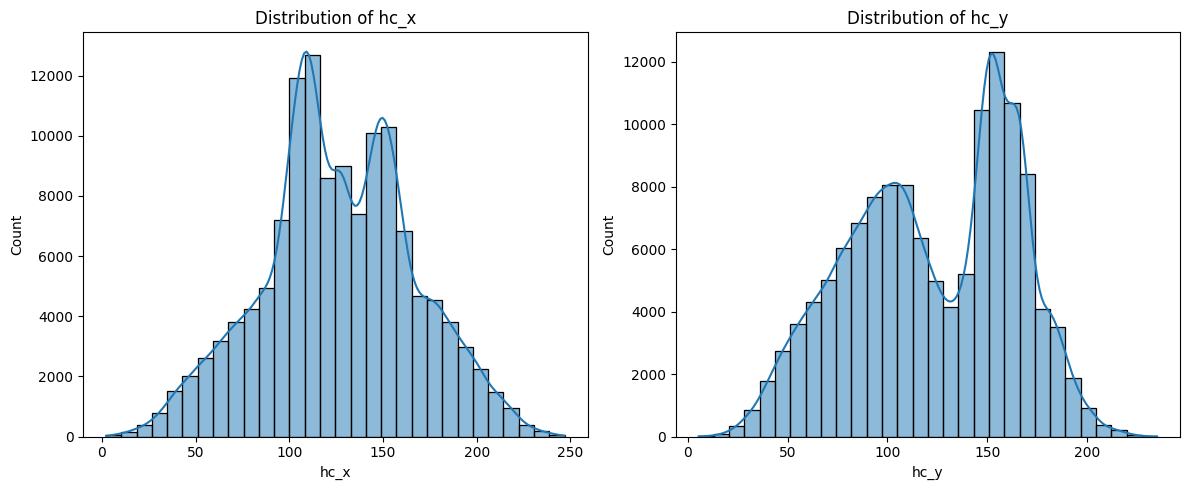

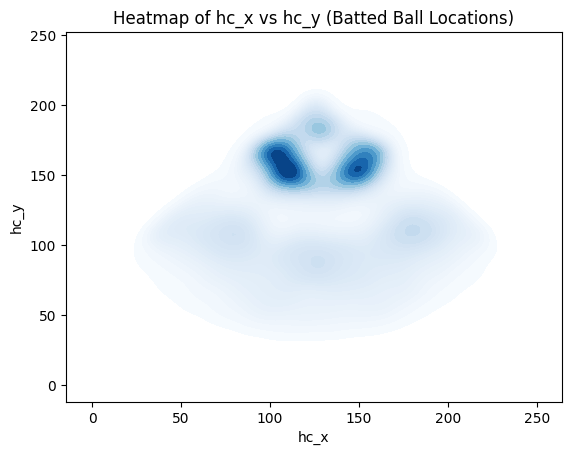

In [11]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(pitch_data['hc_x'].dropna(), bins=30, kde=True)
plt.title("Distribution of hc_x")
plt.xlabel("hc_x")

plt.subplot(1, 2, 2)
sns.histplot(pitch_data['hc_y'].dropna(), bins=30, kde=True)
plt.title("Distribution of hc_y")
plt.xlabel("hc_y")

plt.tight_layout()
plt.show()

# heatmap of hc_x and hc_y
sns.kdeplot(x=pitch_data['hc_x'], y=pitch_data['hc_y'], fill=True, cmap="Blues", levels=25)
plt.title("Heatmap of hc_x vs hc_y (Batted Ball Locations)")
plt.xlabel("hc_x")
plt.ylabel("hc_y")
plt.show()

In [12]:
x_bins = np.linspace(-2, 2, num=3)  #Binning plate_x from -2 to 2 into 4 bins
z_bins = np.linspace(0, 4, num=3)   #Binning plate_z from 0 to 4 into 4 bins

# Assign pitches to zones based on plate_x and plate_z
pitch_data['zone_x'] = np.digitize(pitch_data['plate_x'], bins=x_bins, right=False)
pitch_data['zone_z'] = np.digitize(pitch_data['plate_z'], bins=z_bins, right=False)

#single zone identifier
pitch_data['zone'] = pitch_data['zone_x'].astype(str) + '-' + pitch_data['zone_z'].astype(str)
zone_xwoba = pitch_data.groupby(['batter', 'pitch_type', 'zone'])['estimated_woba_using_speedangle'].mean().reset_index()

pitch_data = pitch_data.merge(zone_xwoba, on=['batter', 'pitch_type', 'zone'], suffixes=('', '_zone_avg'))



In [13]:
pitch_data.sample(10)

,pitch_type,release_speed,release_pos_x,release_pos_z,batter,pitcher,events,description,zone,des,game_type,stand,p_throws,type,balls,strikes,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,hc_x,hc_y,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,release_pos_y,estimated_woba_using_speedangle,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,bat_win_exp,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,arm_angle,cluster_label,zone_x,zone_z,estimated_woba_using_speedangle_zone_avg
128612,FS,83.2,-2.51,5.70,660271,592332,field_out,hit_into_play,2-1,Shohei Ohtani flies out sharply to center fiel...,R,L,R,X,3,2,-1.23,0.18,0.28,1.93,NaN,NaN,NaN,119.58,36.52,NaN,8.847529,-120.746074,-2.474554,-13.760786,24.800616,-30.125811,3.55,1.63,401.0,106.6,22.0,83.2,1912.0,6.6,744947,53.92,1.526,6.0,2,6,Split-Finger,0,0,236.0,0.015,-0.210,80.0,8.0,2.812,0.210,0.478,1,0,37.0,1.0,2,1,0.252714
31123,FF,98.7,2.83,6.02,665862,676979,NaN,foul,2-2,Jazz Chisholm Jr. strikes out swinging.,R,L,L,S,0,2,0.88,1.46,1.35,3.08,NaN,NaN,660644.0,NaN,NaN,NaN,-6.139741,-143.430230,-5.943980,13.556720,36.308643,-10.879800,3.63,1.69,5.0,64.3,-33.0,99.2,2543.0,6.9,746044,53.64,NaN,NaN,25,3,4-Seam Fastball,0,3,137.0,0.000,0.000,60.0,6.0,NaN,0.000,0.263,2,1,36.0,2.0,2,2,0.328779
291164,FF,95.0,-1.91,4.61,668804,664747,NaN,ball,1-3,Bryan Reynolds called out on strikes.,R,L,R,B,1,1,-0.24,0.86,-1.15,4.23,NaN,NaN,641511.0,NaN,NaN,NaN,2.602296,-138.413331,2.759888,-3.619694,28.056617,-21.740740,2.99,1.57,NaN,NaN,NaN,98.0,2563.0,7.7,746695,52.78,NaN,NaN,66,3,4-Seam Fastball,1,6,224.0,0.000,0.042,NaN,NaN,NaN,-0.042,0.994,1,4,12.0,0.0,1,3,0.344566
321539,FF,91.8,-2.31,5.83,660688,592332,NaN,foul,2-2,Keibert Ruiz lines out to first baseman Vladim...,R,L,R,S,0,0,-0.88,1.51,0.00,2.34,NaN,NaN,NaN,NaN,NaN,NaN,7.807178,-133.366615,-6.307674,-12.084404,27.231895,-12.971813,3.39,1.61,170.0,76.7,66.0,92.7,2254.0,6.8,744862,53.72,NaN,NaN,35,1,4-Seam Fastball,0,4,214.0,0.000,-0.023,69.0,7.0,NaN,0.023,0.114,2,1,35.0,0.0,2,2,0.300427
639599,SI,94.9,-2.28,5.31,621512,694738,NaN,foul,1-2,Tomás Nido walks.,R,R,R,S,1,1,-1.41,0.32,-0.40,2.87,NaN,664056.0,NaN,NaN,NaN,NaN,8.122503,-137.978991,-1.406379,-19.787970,32.322630,-28.030691,3.21,1.55,198.0,77.5,19.0,95.4,1905.0,6.8,745346,53.73,NaN,NaN,31,3,Sinker,0,3,238.0,0.000,-0.066,69.0,7.0,NaN,0.066,0.816,1,1,26.0,1.0,1,2,0.288857
587441,FF,93.5,-2.05,5.91,571912,608678,NaN,ball,2-3,Luke Maile flies out to left fielder Robbie Gr...,R,R,R,B,1,0,-0.51,1.57,0.11,4.06,NaN,NaN,NaN,NaN,NaN,NaN,6.719804,-135.945698,-2.422635,-7.946320,33.092370,-12.442464,3.14,1.45,NaN,NaN,NaN,93.2,2250.0,6.4,746811,54.10,NaN,NaN,48,2,4-Seam Fastball,0,5,219.0,0.000,0.062,NaN,NaN,NaN,-0.062,0.972,1,2,40.0,0.0,2,3,0.689131
14288,FF,97.6,-1.42,6.31,668904,683232,double,hit_into_play,2-2,Royce Lewis doubles (2) on a sharp line drive ...,R,R,R,X,1,2,-0.38,1.42,0.74,2.63,NaN,NaN,621043.0,182.25,63.43,NaN,6.773177,-141.876375,-7.777838,-6.646445,30.283383,-11.443544,3.47,1.65,340.0,104.1,17.0,99.1,2357.0,7.0,745896,53.48,0.572,5.0,76,4,4-Seam Fastball,10,8,191.0,0.022,1.038,73.0,8.0,0.865,-1.038,0.943,1,4,64.0,1.0,2,2,0.333137
656280,FS,88.4,-2.20,5.67,663993,656557,NaN,foul,1-2,"Nathaniel Lowe grounds into a force out, first...",R,L,R,S,0,1,-1.02,-0.53,-0.81,2.79,NaN,669701.0,666969.0,NaN,NaN,NaN,5.501946,-128.712113,0.121047,-12.498245,25.724548,-38.287330,3.38,1.52,103.0,75.5,8.0,88.2,1949.0,6.1,746919,54.42,NaN,NaN,24,2,Split-Finger,2,1,256.0,0.000,-0.093,74.0,7.0,NaN,0.093,0.429,2,1,22.0,1.0,1,2,0.246500
358539,FC,89.7,-2.17,5.50,663728,641540,NaN,swinging_strike,2-2,Cal Raleigh homers (6) on a fly ball to right ...,R,L,R,S,0,0,0.18,0.76,0.22,3.79,NaN,641487.0,NaN,NaN,NaN,NaN,5.596806,-130.565701,0.137961,0.919089,26.243442,-23.6694

In [14]:
print(pitch_data['zone_x'].value_counts())
print()
print(pitch_data['zone_z'].value_counts())

zone_x
2    380787
1    344460
3      8464
0      5323
Name: count, dtype: int64

zone_z
2    438052
1    264677
3     28599
0      7706
Name: count, dtype: int64


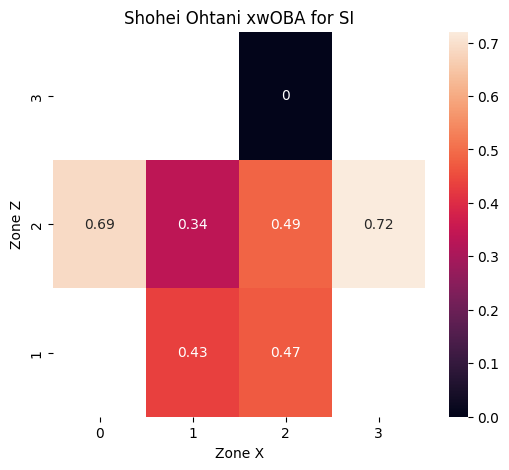

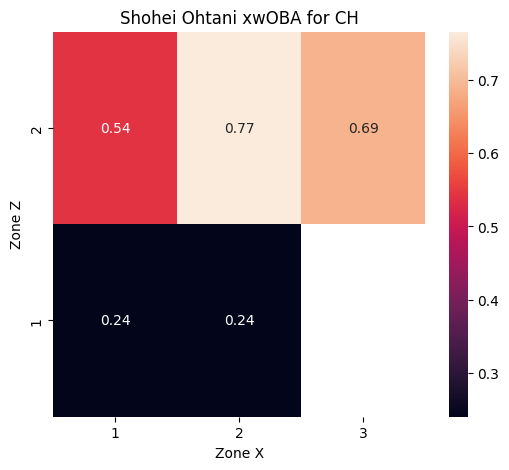

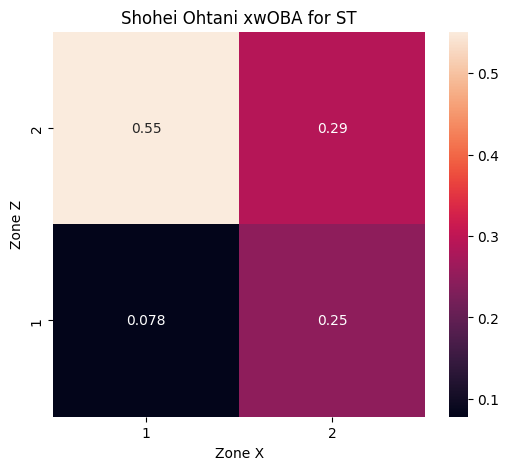

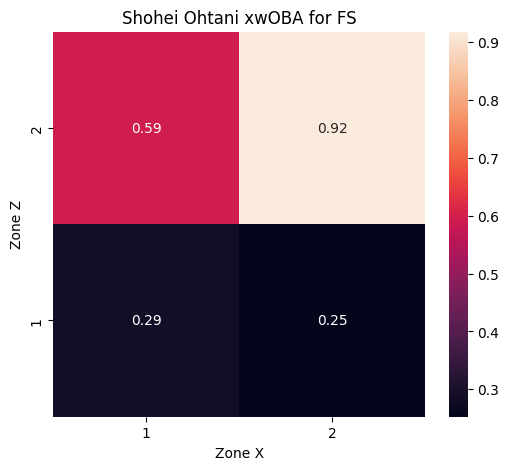

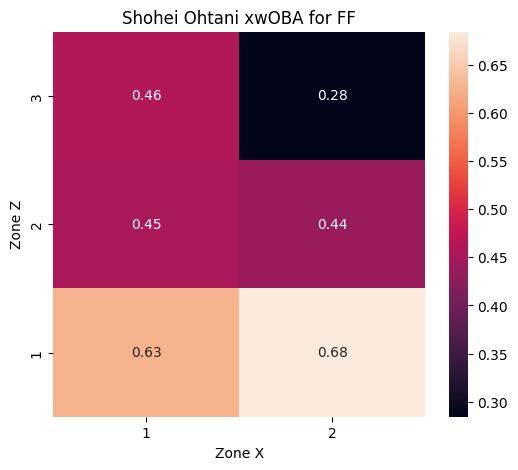

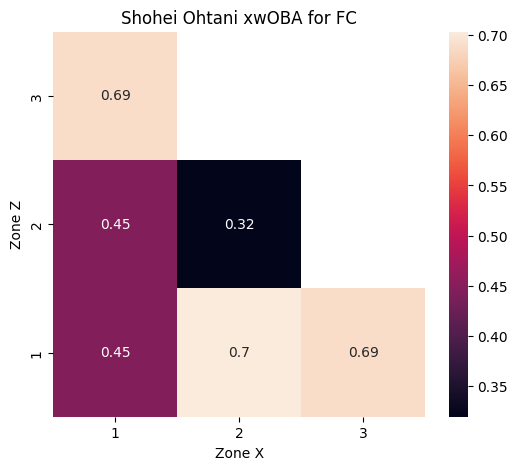

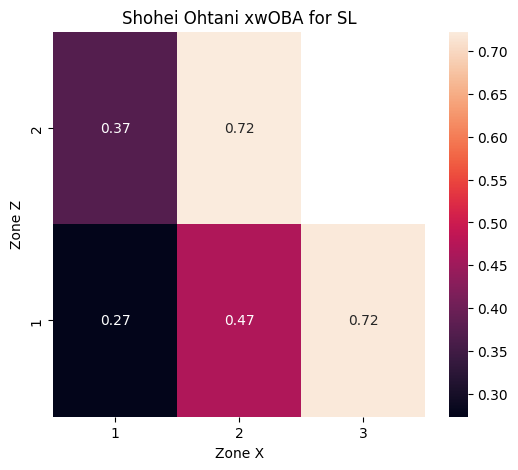

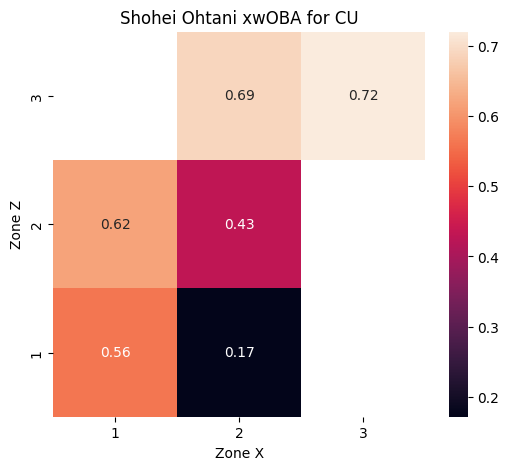

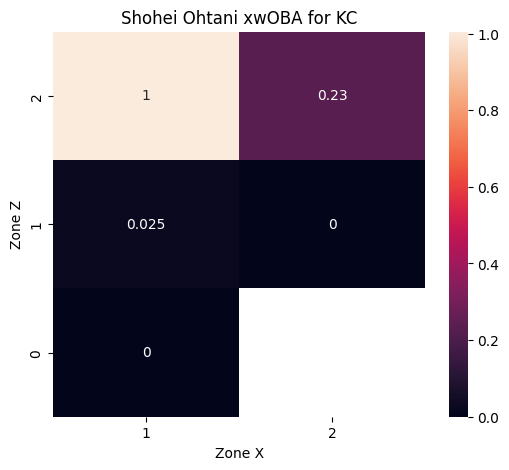

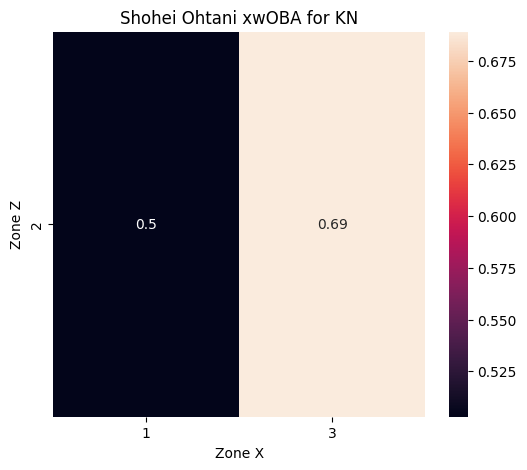

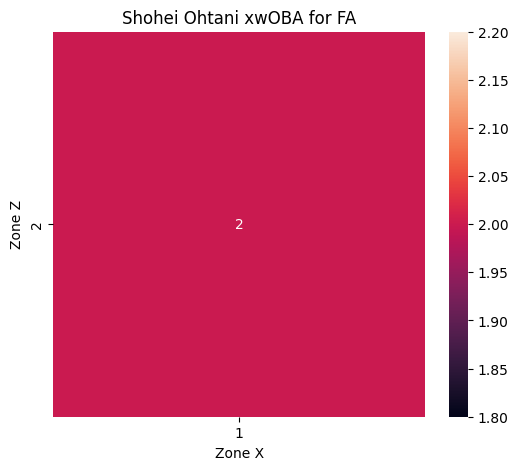

In [31]:
ohtani_data = pitch_data[pitch_data['batter'] == 660271]
ohtani_pitch_types = ohtani_data['pitch_type'].unique()

for pitch in ohtani_pitch_types:
    pitch_df = ohtani_data[ohtani_data['pitch_type'] == pitch]
    
    pivot_table = pitch_df.pivot_table(
        values='estimated_woba_using_speedangle_zone_avg', 
        index='zone_z', columns='zone_x', aggfunc='mean')

    if pivot_table.empty:  #not every hitter faced every pitch last season
        continue
        
    plt.figure(figsize=(6, 5))
    sns.heatmap(pivot_table, annot=True, cbar=True)
    plt.xlabel("Zone X")
    plt.ylabel("Zone Z")
    plt.title(f"Shohei Ohtani xwOBA for {pitch}")

    plt.gca().invert_yaxis()  
    plt.show()

## Probably want to define a better success metric than just xwOBA, the zones that are out of the typical strike zone get a big boost when the hitter doesn't swing at the pitch

In [25]:
pitch_data_bip = pitch_data[pitch_data['description'] == 'hit_into_play']

features = ['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'spin_axis',
            'release_extension', 'estimated_woba_using_speedangle_zone_avg', 'cluster_label', 'n_thruorder_pitcher']

target = 'estimated_woba_using_speedangle'
pitch_data_clean = pitch_data_bip.dropna(subset=['estimated_woba_using_speedangle'])
pitch_data_encoded = pd.get_dummies(pitch_data_clean, columns=['pitch_type'])
features = [col for col in features if col in pitch_data_encoded.columns]
X_train, X_test, y_train, y_test = train_test_split(pitch_data_encoded[features], 
                                                    pitch_data_encoded['estimated_woba_using_speedangle'], test_size=0.2, random_state=4400)

xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=4400)

param_grid = {'max_depth': [2, 4, 6, 8],
              'learning_rate': [0.05, 0.1, 0.2],
              'n_estimators': [100, 200, 300],
              'subsample': [0.85, 0.9, 0.95],
              'colsample_bytree': [0.6, 0.7, 0.8],
              'reg_lambda': [0.1, 1, 10],          
              'reg_alpha': [0.1, 1, 10]}


In [26]:
grid_search = GridSearchCV(xgb_regressor, param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)

best_params, rmse

Fitting 3 folds for each of 2916 candidates, totalling 8748 fits


({'colsample_bytree': 0.7,
  'learning_rate': 0.05,
  'max_depth': 4,
  'n_estimators': 300,
  'reg_alpha': 10,
  'reg_lambda': 1,
  'subsample': 0.85},
 0.36141080750151183)

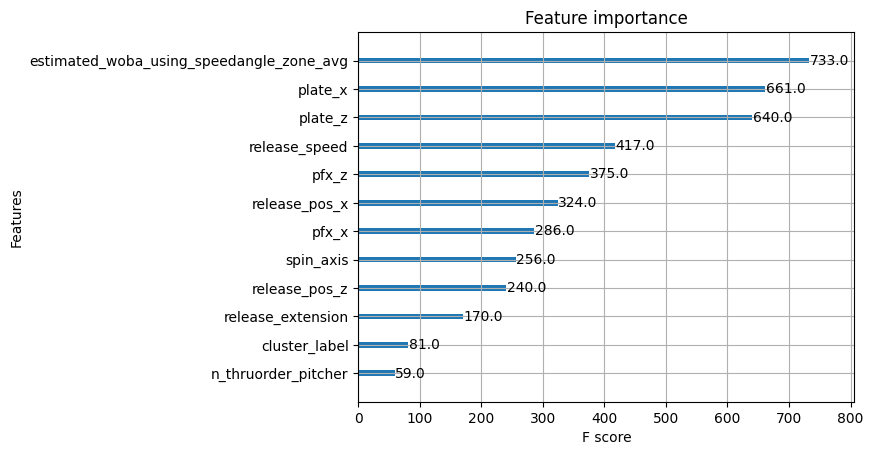

In [27]:
xgb.plot_importance(best_model, importance_type='weight', max_num_features=12)
plt.show()